Author: Boammani Aser Lompo

Colored MNIST (biased) experiment to verify imbalance dynamics:
- Build 2-label dataset (digits 0 vs 1) with spurious COLOR background correlated to label.
- Flip the color with probability epsilon to create a minority "bias-conflicting" group.
- Train frozen backbone + linear softmax head with (near) full-batch GD and constant step size h.
- Log group-wise p_y trajectories, rescaled residuals, and balanced test loss.


## Setup

In [ ]:
!pip install torch torchvision matplotlib

In [1]:
import torch, os
import torch.nn.functional as F
from imb_utils import Config, set_seed, ensure_dir, make_colored_mnist_biased, SmallBackbone, LinearHead, pretrain_backbone_on_plain_mnist, cache_features
import numpy as np
import matplotlib.pyplot as plt
import json

## Run Experiment

In [2]:
def run_experiment(cfg: Config):
    set_seed(cfg.seed)
    ensure_dir(cfg.out_dir)
    device = cfg.device

    # --- build data
    train_ds, bal_test_ds, (pre_xs, pre_ys) = make_colored_mnist_biased(cfg)

    # --- pretrain backbone and freeze
    backbone = SmallBackbone(out_dim=cfg.out_dim).to(device)
    backbone, pre_head = pretrain_backbone_on_plain_mnist(cfg, backbone, pre_xs, pre_ys)
    for p in backbone.parameters(): p.requires_grad = False
    backbone.eval(); pre_head.eval()

    F_train, y_train, g_train = cache_features(backbone, pre_head, train_ds, device)
    F_test,  y_test,  g_test  = cache_features(backbone, pre_head, bal_test_ds, device)    
    N, d = F_train.shape

    # --- Head and optimizer
    in_dim = F_train.shape[1]      # d_r + d_s
    head = LinearHead(in_dim=in_dim).to(device)
    
    # symmetric (zero) init so GD preserves antisymmetry without enforcing it
    with torch.no_grad():
        head.fc.weight.zero_()
        head.fc.bias.zero_()
    opt  = torch.optim.SGD(head.parameters(), lr=cfg.head_lr, momentum=0.0, weight_decay=0.0)
    
    # --- Helpers that work on cached features (no dataloaders in the loop)
    @torch.no_grad()
    def group_true_class_probs_cached():
        head.eval()
        Z = head(F_train)                      # (N, 2)
        P = F.softmax(Z, dim=1)
        p_true = P[torch.arange(N, device=device), y_train]
        p_min = p_true[g_train == 1].mean().item() if (g_train == 1).any() else float('nan')
        p_maj = p_true[g_train == 0].mean().item() if (g_train == 0).any() else float('nan')
        head.train()
        return {"p_min": p_min, "p_maj": p_maj}

    @torch.no_grad()
    def balanced_test_loss_cached():
        head.eval()
        Z = head(F_test)
        loss = F.cross_entropy(Z, y_test, reduction='mean').item()
        head.train()
        return loss

    # --- Logs
    logs = {
        "t": [], "p_min": [], "p_maj": [],
        "one_minus_pmin": [], "one_minus_pmaj": [],
        "rescaled_min": [], "rescaled_maj": [],
        "balanced_test_loss": [],
    }

    T, h, eps = cfg.head_steps, cfg.head_lr, cfg.epsilon
    log_every = getattr(cfg, "log_every", 200)

    # --- Training loop: TRUE full-batch GD on cached features (fast)
    head.train()
    for t in range(1, T + 1):
        Z = head(F_train)                      # (N, 2)
        loss = F.cross_entropy(Z, y_train)     # scalar
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if (t % log_every == 0) or (t in (1, T)):
            gp = group_true_class_probs_cached()
            p_min, p_maj = gp["p_min"], gp["p_maj"]
            r_min = (1.0 - p_min) * (4.0 * eps * h * t)
            r_maj = (1.0 - p_maj) * (4.0 * (1.0 - eps) * h * t)
            bal_loss = balanced_test_loss_cached()

            logs["t"].append(t)
            logs["p_min"].append(p_min)
            logs["p_maj"].append(p_maj)
            logs["one_minus_pmin"].append(1.0 - p_min)
            logs["one_minus_pmaj"].append(1.0 - p_maj)
            logs["rescaled_min"].append(r_min)
            logs["rescaled_maj"].append(r_maj)
            logs["balanced_test_loss"].append(bal_loss)
            if (t % cfg.print_every == 0) or (t in (1, T)):
                print(f"[t={t:6d}] loss={loss.item():.4f}  "
                      f"p_min={p_min:.4f} p_maj={p_maj:.4f}  "
                      f"rescaled_min={r_min:.3f} rescaled_maj={r_maj:.3f}  "
                      f"bal_test={bal_loss:.4f}")

    # --- Plots (unchanged)
    import numpy as np, matplotlib.pyplot as plt, os
    ensure_dir(cfg.out_dir)
    t = np.array(logs["t"], dtype=float)

    plt.figure(); plt.loglog(t, np.array(logs["one_minus_pmin"])+1e-12, label="1 - p_y (minority)")
    plt.loglog(t, np.array(logs["one_minus_pmaj"])+1e-12, label="1 - p_y (majority)")
    plt.xlabel("t (steps)"); plt.ylabel("1 - p_y"); plt.title(f"Decay | eps={eps}, h={h}")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(cfg.out_dir, "one_minus_py_loglog.png"), dpi=180)

    plt.figure(); plt.plot(t, logs["rescaled_min"], label="(1-p_y^min) * 4 eps h t")
    plt.plot(t, logs["rescaled_maj"], label="(1-p_y^maj) * 4 (1-eps) h t")
    plt.axhline(1.0, ls="--", alpha=0.6, label="=1 (theory)")
    plt.xlabel("t (steps)"); plt.ylabel("rescaled residual"); plt.title("Scaling collapse")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(cfg.out_dir, "rescaled_collapse.png"), dpi=180)

    # empirical curve
    plt.figure(); plt.plot(t, np.array(logs["balanced_test_loss"]), label="Empirical")
    theory = 1.0 / (8.0 * eps * (1.0 - eps) * h * t)
    plt.plot(t, theory, "--", label="Theory: 1 / [8 ε (1−ε) h t]")
    plt.xlabel("t (steps)"); plt.ylabel("Balanced CE loss (test)"); plt.title("Balanced test loss over training")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(cfg.out_dir, "balanced_test_loss_over_time.png"), dpi=180)
    
    return logs

In [ ]:
for k in range(1, 2):
    cfg = Config()
    cfg.epsilon = k/100 #0.1
    cfg.head_lr = 1e-2
    cfg.head_steps = 3000000
    cfg.out_dim = 256
    cfg.log_every = 200
    cfg.print_every = 300000
    cfg.out_dir = f"./runs/notebook_{cfg.epsilon}_{cfg.out_dim}"
    
    # This now only affects caching speed:
    cfg.eval_batch_size = 8192
    
    logs = run_experiment(cfg)
    
    with open(os.path.join(cfg.out_dir, "logs.json"), "w") as f:
        json.dump(logs, f, indent=2)
    print(f"Saved logs and plots to: {cfg.out_dir}")

## Visualisaton

#### Dataset sample

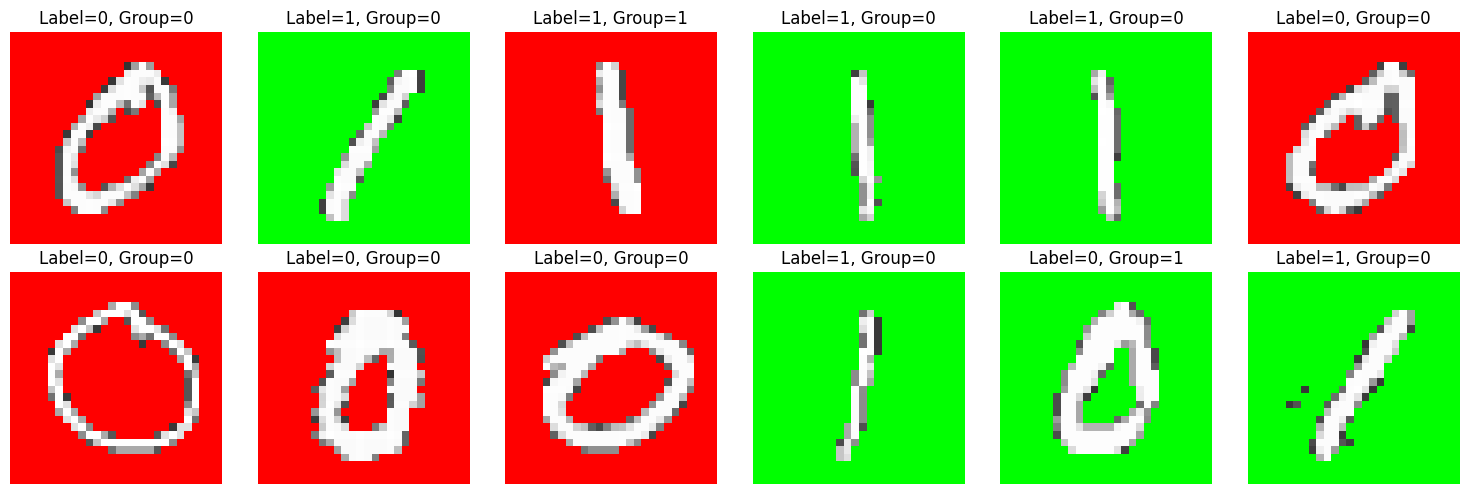

In [3]:
from imb_utils import show_colored_mnist_examples
cfg = Config()
cfg.out_dir = "."

train_ds, bal_test_ds, (pre_xs, pre_ys) = make_colored_mnist_biased(cfg)
show_colored_mnist_examples(train_ds, cfg, n_per_group=6)

#### Aggregated experiment results

In [2]:
from imb_utils import load_all_runs, plot_1_over_t_decay, plot_speed_vs_epsilon_at_last, plot_balanced_loss_over_time, plot_balanced_loss_normalized_at_last
cfg = Config()
cfg.out_dir = "."

H = 1e-2   # head_lr used during the runs

runs = load_all_runs("./runs")
eps_list = list(runs.keys())
print(f"Loaded {len(runs)} runs. epsilons: {eps_list[:10]}{'...' if len(eps_list)>10 else ''}")

Loaded 50 runs. epsilons: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]...


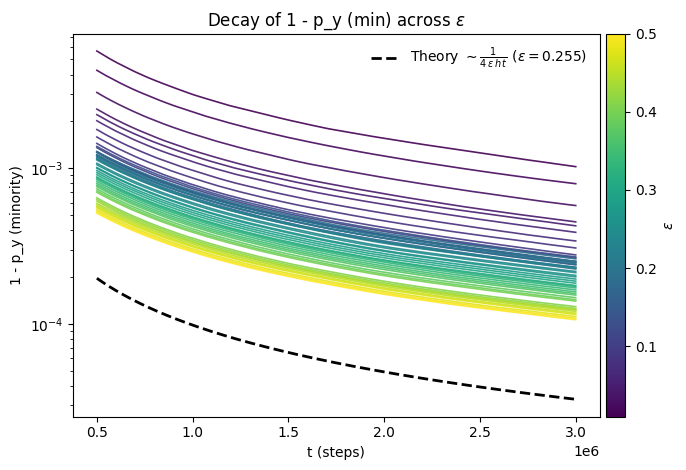

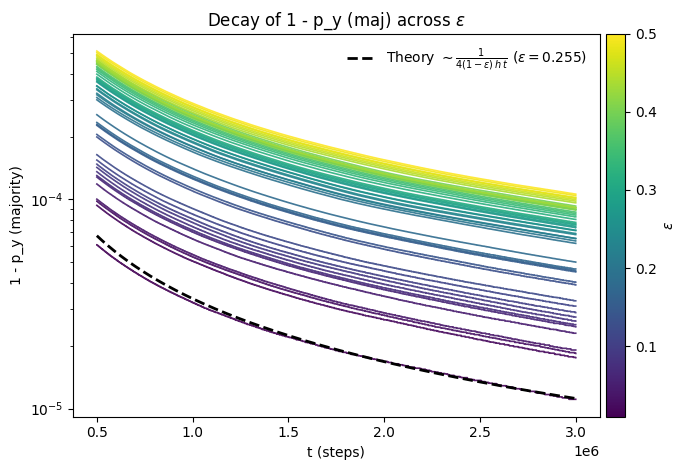

In [3]:
plot_1_over_t_decay(runs, H, cfg, group="min", t_min=5e5)
plot_1_over_t_decay(runs, H, cfg, group="maj", t_min=5e5)

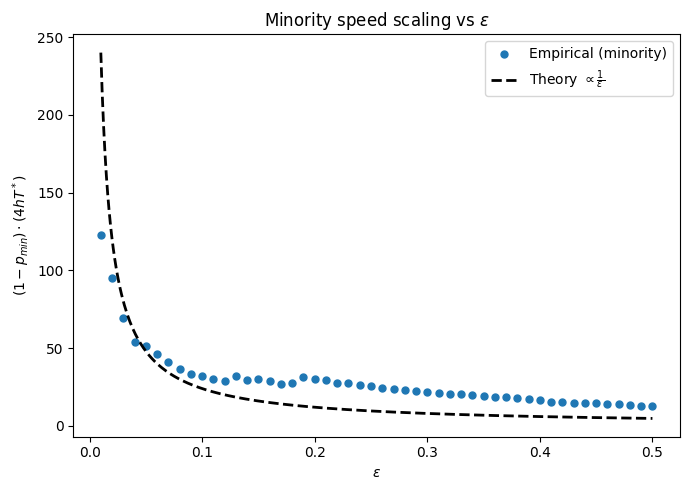

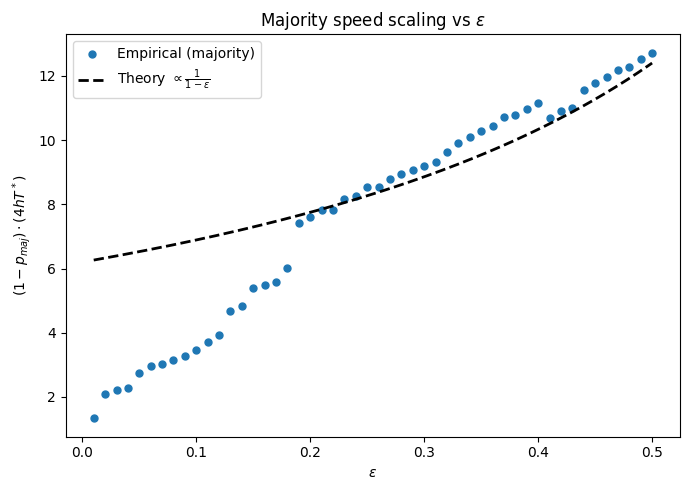

In [3]:
plot_speed_vs_epsilon_at_last(runs, H, cfg)

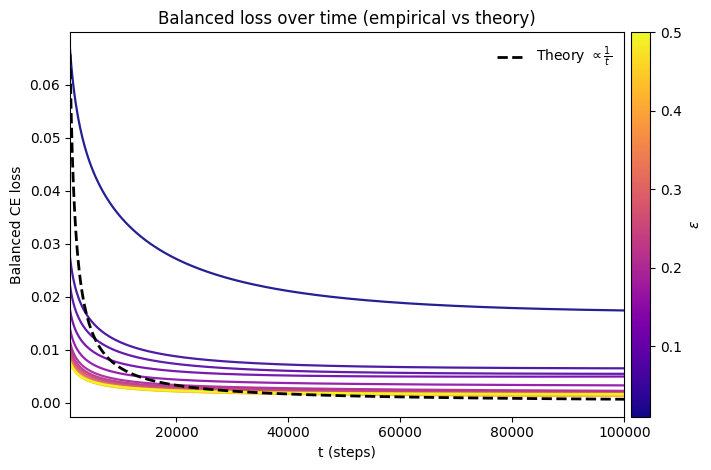

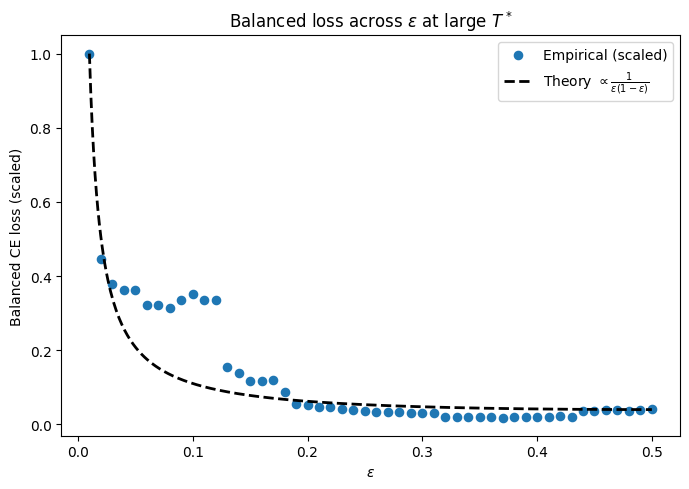

In [3]:
plot_balanced_loss_over_time(runs, H, cfg, n_eps_to_show=15, t_min=1e3, t_max=1e5)
plot_balanced_loss_normalized_at_last(runs, H, cfg)